# Deterministic guarantees with output range analysis
In this tutorial we will show how to guarantee feasibility and even stability for AMPC on linear systems using Output Range Analysis. First, we will need to install some packages and download the data from Github

In [2]:
%%capture
!apt-get install -y libcdd-dev
!pip install pycddlib

In [3]:
%%capture
!git clone https://github.com/JoshuaAda/2025_dycops_workshop.git

In [4]:
%%capture
!pip install casadi
!pip install pypoman
!pip install polytope
!pip install torch
!pip install cvxpy
!pip install control
!pip install scipy
!pip install do_mpc

import numpy as np
import matplotlib.pyplot as plt
import sys
from casadi import *
import os

#rel_do_mpc_path = os.path.join('2025_dycops_workshop')
#sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc
from do_mpc.tools import Timer

## Model
We consider the oscillating mass example as described in the original paper and in our do-it-yourself AMPC notebook. That is the model is defined as a discrete 2D-model


In [5]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)
x=model.set_variable('_x','x',(2,1))
u=model.set_variable('_u','u')
A=np.array([[0.5403, -0.8415],[0.8415, 0.5403]])
B=np.array([[-0.4597],[0.8415]])
model.set_rhs('x',A@x+B@u)
model.setup()

## Calculate LQR gain, MPI set for stability
Now there is one difference. We are now looking to stabilize our MPC and later our AMPC. For this, we need to get the LQR feedback controller and the control invariant set in which we ensure to remain, if the LQR is used. Additionally, we need the terminal cost. The following algorithm iteratively computes this maximum control invariant set

LQR controller: [[0.25012961 0.8290033 ]]
Closed-loop control matrix: [[ 0.65528458 -0.46040718]
 [ 0.63101594 -0.15730628]]
Algorithm converged after 2 step(s).


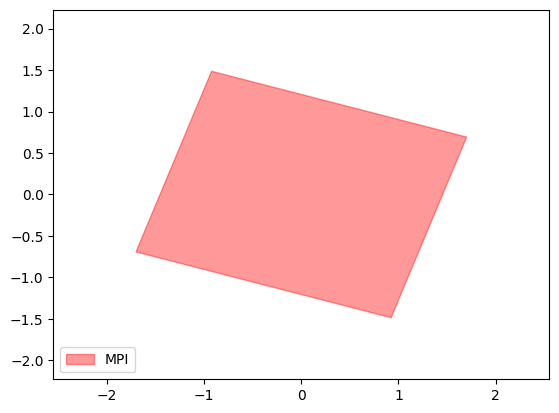

In [7]:
from control import dare
from pypoman import compute_polytope_vertices
from pypoman.polygon import plot_polygon
from numpy.linalg import matrix_power as mp



# state constraints matrix
F = np.array([[1 / 5, 0],
              [-1 / 5, 0],
              [0, 1 / 5],
              [0, -1 / 5]])

# input constraints matrix
G = np.array([[1],
              [-1]])

Q=np.array([[2,0],[0,2]])

R=np.array([1])

# Compute optimal feedback matrix by solving the DARE
P_lqr, _, K_lqr = dare(A, B, Q, R)
print("LQR controller: "+str(K_lqr))

# convert to numpy array
K_lqr = -np.array(K_lqr)

# Update the closed-loop
A_cl = A + B @ K_lqr
# Maximum number of iterations
max_iter = 100
print("Closed-loop control matrix: "+str(A_cl))

# Initialize matrix describing the invariant set
invariant_mat = np.zeros((0, 2))

# run loop
for n_f in range(max_iter):

    # extend the matrix describing the invariant set
    invariant_mat = np.vstack([invariant_mat, F @ mp(A_cl, n_f), G @ K_lqr @ mp(A_cl, n_f)])

    # termination criterion
    one_vec = np.ones((invariant_mat.shape[0], 1))

    # compute vertices of current iterate of the maximum invariant set
    verts = compute_polytope_vertices(invariant_mat, one_vec)

    # compute predecessor states of the current vertices
    verts_next = [A_cl @ np.reshape(vert, (-1, 1)) for vert in verts]

    # check if all verts lie inside the current iterate of the maximum invariant set
    in_omega = [all(invariant_mat @ vert <= one_vec+1e-6) for vert in verts_next]

    # if all predecessor verts inside the current iterate of the maximum invariant set -> break
    if all(in_omega):
        print('Algorithm converged after ' + str(n_f + 1) + ' step(s).')
        break
plot_polygon(verts,color='r',alpha=0.4,resize=True)
plt.gca().legend(("MPI",),loc="lower left")

## MPC
Now we can use this MPI set as the terminal set, the cost of the LQR as the terminal cost in our MPC. This adapts the MPC to the following code in do-mpc

In [8]:
%%capture
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 3,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.1,
}
mpc.set_param(**setup_mpc)
mpc.settings.supress_ipopt_output()
_x=model.x['x']
_u=model.u['u']
lterm=_x.T@Q@_x+_u.T@R@_u
mterm=_x.T@P_lqr@_x
mpc.set_objective(mterm,lterm)

mpc.bounds['lower','_x','x']=np.array([[-5],[-5]])
mpc.bounds['upper','_x','x']=np.array([[5],[5]])
mpc.bounds['lower','_u','u']=np.array([[-1]])
mpc.bounds['upper','_u','u']=np.array([[1]])
mpc.prepare_nlp()
#print(mpc.opt_x['_x'])
extra_cons= invariant_mat@mpc.opt_x['_x', -1, 0][0][0:2]-1
mpc.nlp_cons.append(
       extra_cons
    )
mtx=np.zeros(extra_cons.shape)
mtx.fill(-inf)

mpc.nlp_cons_lb.append(mtx)
mpc.nlp_cons_ub.append(np.zeros(extra_cons.shape))
mpc.create_nlp()

## Estimator and Simulator
Estimator and Simulator are easily obtained.

In [9]:
estimator = do_mpc.estimator.StateFeedback(model)
simulator=do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)
simulator.setup()

## Visualization and closed-loop simulation
Of course, we can again visualize our stable MPC.

[[ 1.03367135]
 [-0.0715296 ]]


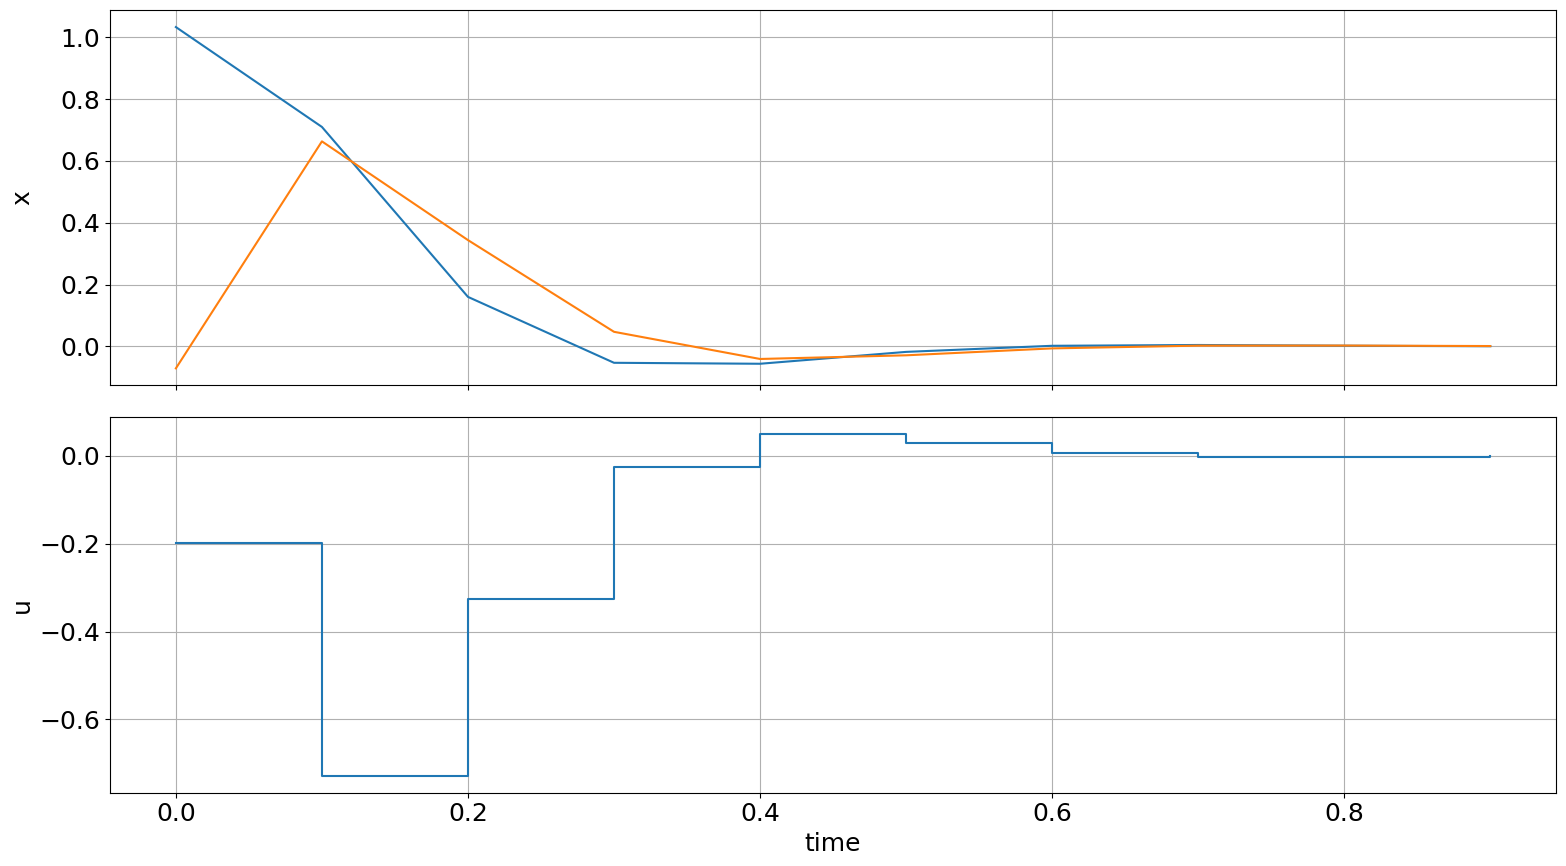

In [10]:
np.random.seed(99)

# Initial state
mpc.reset_history()
simulator.reset_history()
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
print(x0)
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()
for k in range(10):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

## Approximate MPC
Now lets define our approximate MPC as before in the first notebook. We see how efficiently we can generate the AMPC using do-mpc

----------------------------------
ApproxMPC(
  (net): FeedforwardNN(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)
----------------------------------
Path from trainer to sampled files
 2025_dycops_workshop/02_Det_guarantees_linear_ora/sampling/my_dataset/data_my_dataset_opt.pkl


/usr/local/lib/python3.11/dist-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/_device.py:104: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return func(*args, **kwargs)


epoch :  9
train_loss :  0.9470802545547485
val_loss :  0.9398258328437805
-------------------------------
epoch :  19
train_loss :  0.8764371871948242
val_loss :  0.8636314868927002
-------------------------------
epoch :  29
train_loss :  0.8155613541603088
val_loss :  0.7985264658927917
-------------------------------
epoch :  39
train_loss :  0.7628744840621948
val_loss :  0.7424001693725586
-------------------------------
epoch :  49
train_loss :  0.7166591882705688
val_loss :  0.6933609843254089
-------------------------------
epoch :  59
train_loss :  0.6749097108840942
val_loss :  0.6492908000946045
-------------------------------
epoch :  69
train_loss :  0.6360975503921509
val_loss :  0.6079565286636353
-------------------------------
epoch :  79
train_loss :  0.5989383459091187
val_loss :  0.5684928894042969
-------------------------------
epoch :  89
train_loss :  0.562126100063324
val_loss :  0.5291863679885864
-------------------------------
epoch :  99
train_loss :  0.52

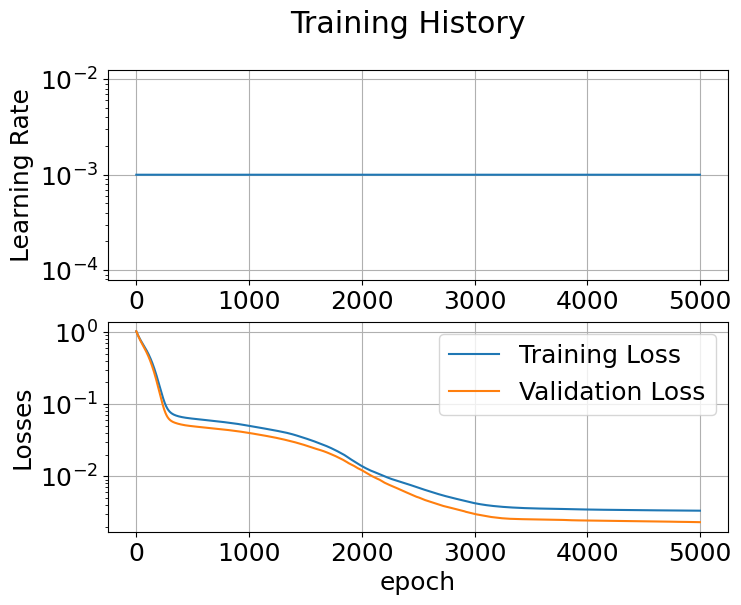

In [11]:
import torch
torch.manual_seed(42)
approx_mpc=do_mpc.approximateMPC.ApproxMPC(mpc)
approx_mpc.settings.act_fn='relu'
n_l=10
L=1
approx_mpc.settings.n_hidden_layers=L
approx_mpc.settings.n_neurons=n_l
approx_mpc.settings.scaling=False
approx_mpc.setup()

sampler=do_mpc.approximateMPC.AMPCSampler(mpc)
sampler.settings.n_samples = 2000

dataset_name = "my_dataset"
sampler.settings.dataset_name = dataset_name
sampler.setup()
np.random.seed(1)
#sampler.default_sampling()

trainer=do_mpc.approximateMPC.Trainer(approx_mpc)
trainer.settings.show_fig = True
trainer.settings.data_dir='2025_dycops_workshop/02_Det_guarantees_linear_ora/sampling'
trainer.settings.dataset_name = dataset_name
trainer.settings.n_epochs=5000
trainer.setup()

trainer.default_training()


## Closed_loop simulation
Visualization and simulation are identical to the MPC class, we only have to use the simulator data.

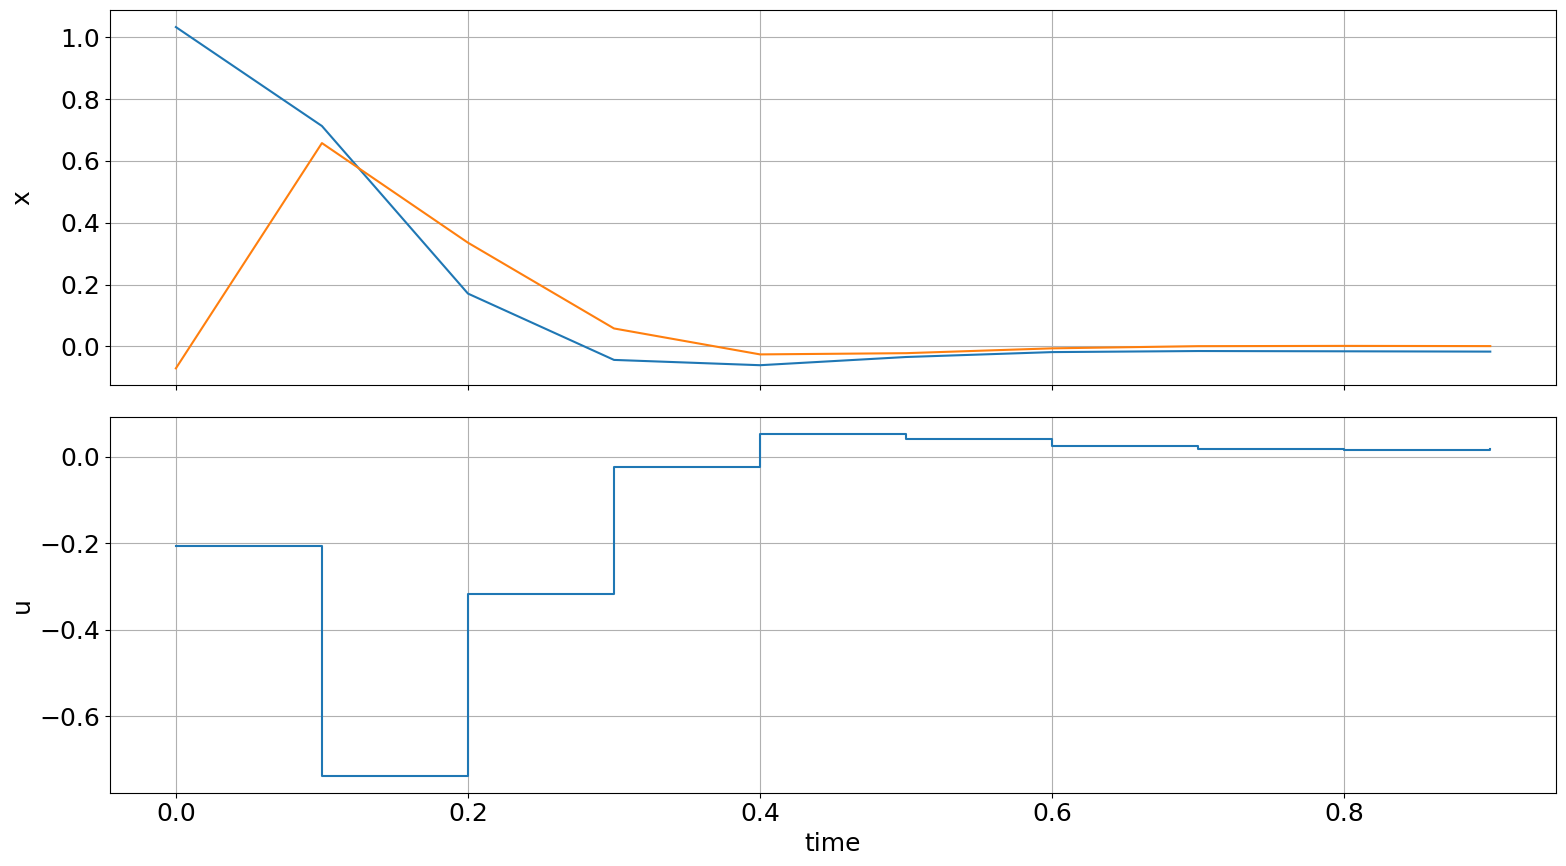

In [ ]:
np.random.seed(99)
# Initial state
mpc.reset_history()
simulator.reset_history()
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()
for k in range(10):
    u0 = approx_mpc.make_step(x0,clip_to_bounds=False)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
_, _, graphics = do_mpc.graphics.default_plot(simulator.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

## Calculate X_in
What we require is a set of X_in in which we guarantee to safely use the AMPC


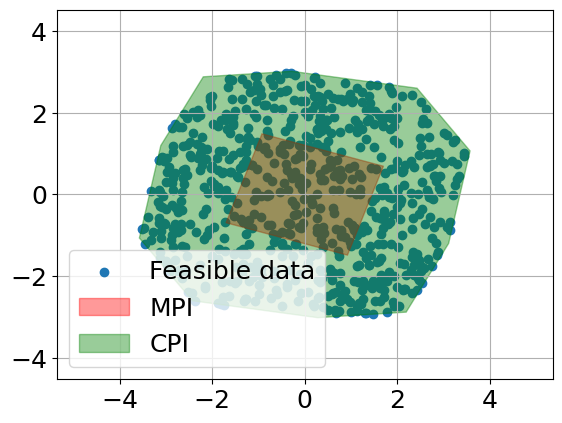

In [12]:
import polytope
import pickle as pkl
from pathlib import Path
import torch
data_dir=trainer.settings.data_dir
data_dir = Path(data_dir)
data_dir = data_dir.joinpath(dataset_name)
data_dir = data_dir.joinpath("data_" + dataset_name + "_opt.pkl")

with open(data_dir, "rb") as f:
    dataset = pkl.load(f)
x0 = torch.tensor(dataset["x0"], dtype=trainer.approx_mpc.torch_data_type).reshape(
            -1, trainer.approx_mpc.mpc.model.n_x
        )
x0=np.array(x0.detach().cpu())
fig,ax=plt.subplots()
plt.scatter(x0[:,0],x0[:,1],label="Feasible data")
N_pred=3
C_in=invariant_mat
c_in=one_vec

plot_polygon(verts,color='r',alpha=0.4,resize=True)

for k in range(N_pred):
    X_mat=np.zeros((len(F)+len(G)+len(C_in),3))
    X_mat[0:F.shape[0],0:F.shape[1]]=F
    X_mat[F.shape[0]:F.shape[0]+G.shape[0],F.shape[1]:F.shape[1]+G.shape[1]]=G

    X_mat[F.shape[0]+G.shape[0]:F.shape[0]+G.shape[0]+len(C_in),0:F.shape[1]+G.shape[1]]=np.concatenate((C_in@A,C_in@B),axis=1)
    ones=np.concatenate((np.ones((F.shape[0]+G.shape[0],1)),c_in),axis=0)
    verts_new=compute_polytope_vertices(X_mat,ones)
    verts_projected=[verts_new[k][0:model.n_x] for k in range(len(verts_new))]

    poly=polytope.qhull(np.array(verts_projected))
    C_in=poly.A
    c_in=poly.b.reshape((len(poly.b),1))
plot_polygon(verts_projected,resize=True)


ax.legend(('Feasible data','MPI','CPI'))


## Output Range analysis for U_1 and forward propagation for X_1
Next, we prepare the first optimization problem to certify the output of the neural network

In [13]:
import cvxpy as cp
M=1e5


u_res=np.zeros((len(G),1))
for i in range(len(G)):
    t=cp.Variable(n_l, integer=True)
    z=cp.Variable(n_l)
    u0=cp.Variable(model.n_u)

    x0=cp.Variable(model.n_x)
    W_1=approx_mpc.net.state_dict()['layers.0.weight']
    b_1=approx_mpc.net.state_dict()['layers.0.bias']
    W_2=approx_mpc.net.state_dict()['layers.2.weight']
    b_2=approx_mpc.net.state_dict()['layers.2.bias']

    objective = cp.Maximize(G[i]@u0)
    prob = cp.Problem(objective,[x0@W_1.T+b_1 <= z,0<=z, x0@W_1.T+b_1+M*t>=z,M*(np.ones(n_l)-t)>=z,t<=1,t>=0,C_in@x0<=c_in,u0==z@W_2.T+b_2])
    prob.solve()
    u_res[i]=u0.value
    print("Maximum and minimum state:"+str(x0.value))
c_u=G*u_res
print("Maximum and minimum input:"+str(c_u))


Maximum and minimum state:[-3.14473 -0.70286]
Maximum and minimum state:[-0.66799  1.72317]
Maximum and minimum input:[[1.0485 ]
 [1.12204]]


/usr/local/lib/python3.11/dist-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Let us test whether this is the case

In [14]:
x=np.array([[-3.14473], [-0.70286]])
print(approx_mpc.make_step(x,clip_to_bounds=False))

[[1.0485]]


In [15]:
for k in range(2):
  approx_mpc.net.layers.append(torch.nn.ReLU())
  approx_mpc.net.layers.append(torch.nn.Linear(model.n_u,model.n_u))

In [16]:
W_2=-approx_mpc.net.state_dict()['layers.2.weight']
b_2=1-np.array(approx_mpc.net.state_dict()['layers.2.bias'].detach().cpu())
W_3=-1
b_3=2
W_4=1
b_4=G[1]
with torch.no_grad():
  approx_mpc.net.layers[2].weight.copy_(torch.tensor(W_2))
  approx_mpc.net.layers[2].bias.copy_(torch.tensor(b_2))
  approx_mpc.net.layers[4].weight.copy_(torch.tensor(W_3))
  approx_mpc.net.layers[4].bias.copy_(torch.tensor(b_3))
  approx_mpc.net.layers[6].weight.copy_(torch.tensor(W_4))
  approx_mpc.net.layers[6].bias.copy_(torch.tensor(b_4))
print(approx_mpc.net.state_dict())

OrderedDict([('layers.0.weight', tensor([[ 0.4783,  0.9277],
        [ 0.3546,  0.7071],
        [-0.1481, -0.3094],
        [-0.7980, -0.3345],
        [ 0.1394, -0.7565],
        [ 0.4684,  0.0043],
        [ 0.3823, -0.1242],
        [-0.2164, -0.2801],
        [ 0.3311,  0.6740],
        [-0.4769,  0.2838]])), ('layers.0.bias', tensor([-1.0642,  0.8639,  0.4342,  0.8930, -0.7779, -0.4699, -1.0017,  0.6085,
         0.8739, -0.8076])), ('layers.2.weight', tensor([[-0.6739,  0.6615, -0.5664,  0.2943,  0.2962,  0.0175,  0.1897, -0.4777,
          0.2506, -0.5013]])), ('layers.2.bias', tensor([0.4705])), ('layers.4.weight', tensor([[-1.]])), ('layers.4.bias', tensor([2.])), ('layers.6.weight', tensor([[1.]])), ('layers.6.bias', tensor([-1.]))])


/usr/local/lib/python3.11/dist-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


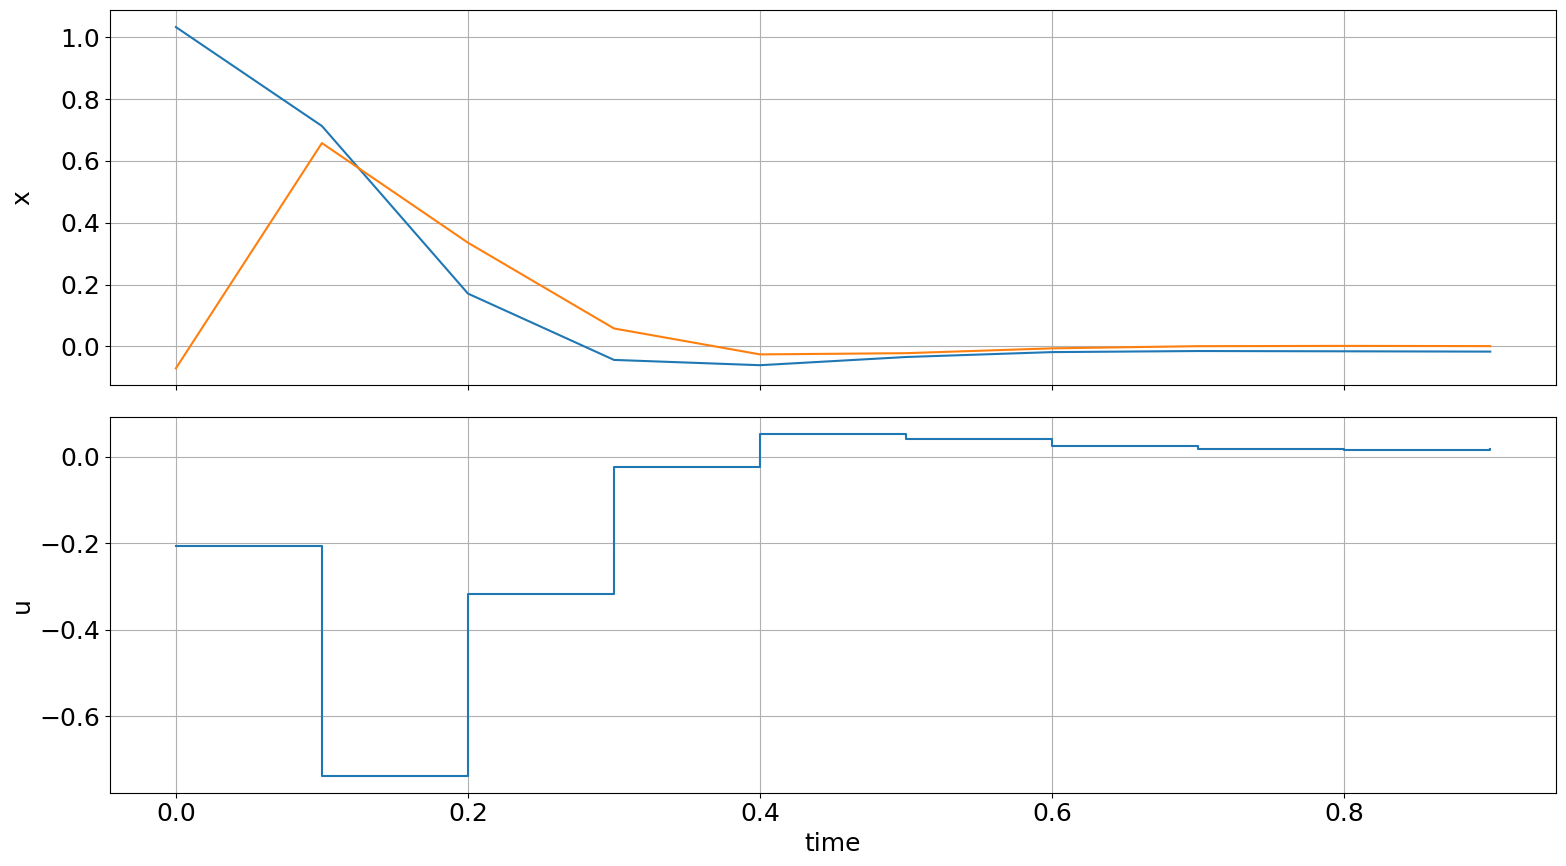

In [17]:
np.random.seed(99)
# Initial state
mpc.reset_history()
simulator.reset_history()
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()
for k in range(10):
    u0 = approx_mpc.make_step(x0,clip_to_bounds=False)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
_, _, graphics = do_mpc.graphics.default_plot(simulator.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

In [18]:
x=np.array([[-3.14473], [-0.70286]])
print(approx_mpc.make_step(x,clip_to_bounds=False))

[[1.]]


## Output range analysis for k=1
In the next section we formulate the optimization problem for a state set range analysis given a certain controller. That is we can find the set where all states will be in after k steps given the system dynamics and the neural network controller.
For feasible CPI set we can now certifiy recursive feasibility for our controller, if the resulting set for k=1 is within the CPI set

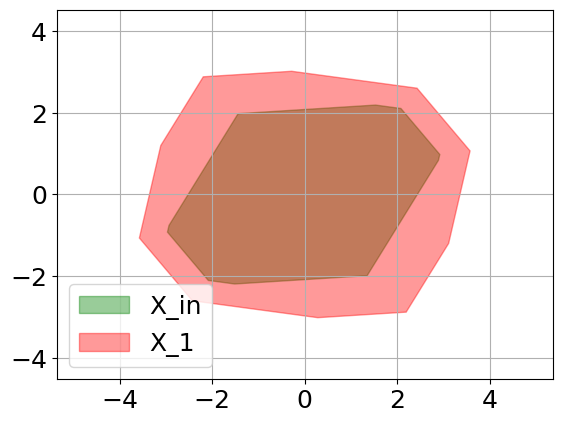

In [19]:

def evaluate_set(C_in,c_in,k,C_out,approx_mpc):
    W_1=approx_mpc.net.state_dict()['layers.0.weight']
    b_1=approx_mpc.net.state_dict()['layers.0.bias']
    W_2=approx_mpc.net.state_dict()['layers.2.weight']
    b_2=approx_mpc.net.state_dict()['layers.2.bias']
    W_3=approx_mpc.net.state_dict()['layers.4.weight']
    b_3=approx_mpc.net.state_dict()['layers.4.bias']
    W_4=approx_mpc.net.state_dict()['layers.6.weight']
    b_4=approx_mpc.net.state_dict()['layers.6.bias']
    M=1e5
    xki_res=np.zeros((len(C_out),model.n_x))
    for i in range(len(C_out)):
        constraints=[]
        t1=cp.Variable((k,n_l), integer=True)
        t2=cp.Variable((k,n_l), integer=True)
        t3=cp.Variable((k,n_l), integer=True)
        z0=cp.Variable((k,model.n_x))
        z1=cp.Variable((k,n_l))
        z2 = cp.Variable((k,model.n_u))
        z3 = cp.Variable((k,model.n_u))
        u=cp.Variable((k,model.n_u))
        x0=cp.Variable(model.n_x)
        xki=cp.Variable(model.n_x)
        constraints.append(C_in@x0<=c_in)
        constraints.append(A@z0[k-1]+B@u[k-1]==xki)
        constraints.append(z0[0]==x0)
        for j in range(k):
            if j>0:
                constraints.append(z0[j]==A@z0[j-1]+B@u[j-1])
            constraints.append(z0[j]@W_1.T+b_1 <= z1[j])
            constraints.append(z1[j]>=0)
            constraints.append(z0[j]@W_1.T+b_1 + M*t1[j] >= z1[j])
            constraints.append(M*(np.ones(n_l)-t1[j])>=z1[j])
            constraints.append(t1[j]<=1)
            constraints.append(t1[j]>=0)

            constraints.append(z1[j]@W_2.T+b_2 <= z2[j])
            constraints.append(z2[j]>=0)
            constraints.append(z1[j]@W_2.T+b_2 + M*t2[j] >= z2[j])
            constraints.append(M*(np.ones(n_l)-t2[j])>=z2[j])
            constraints.append(t2[j]<=1)
            constraints.append(t2[j]>=0)

            constraints.append(z2[j]@W_3.T+b_3 <= z3[j])
            constraints.append(z3[j]>=0)
            constraints.append(z2[j]@W_3.T+b_3 + M*t3[j] >= z3[j])
            constraints.append(M*(np.ones(n_l)-t3[j])>=z3[j])
            constraints.append(t3[j]<=1)
            constraints.append(t3[j]>=0)


            constraints.append(u[j]==z3[j]@W_4.T+b_4)
        objective = cp.Maximize(C_out[i]@xki)
        prob = cp.Problem(objective,constraints)
        prob.solve(verbose=False)
        xki_res[i]=xki.value
        #print(xki.value)
    return xki_res
xki_res=evaluate_set(C_in,c_in,1,C_in,approx_mpc)
#print(xki_res)
c_x=np.zeros((len(C_in),1))
for m in range(len(C_in)):
    c_x[m]=C_in[m,:]@xki_res[m,:].reshape((model.n_x,1))

vertices_x=compute_polytope_vertices(C_in,c_x)
vertices_inv=compute_polytope_vertices(C_in,c_in)
plot_polygon(vertices_x,resize=True)
plot_polygon(vertices_inv,resize=True,color='r')
plt.gca().legend(("X_in","X_1"),loc="lower left")

## Stability with LQR adaption of neural network
Now we have a feasible controller. For stability the controller needs to bring the system in a terminal set after some k steps. Secondly, we also need to ensure that within this terminal set we will reach the origin. While the first part can be easily verified with the same optimization problem we used for the recursive feasibility, the second part is not in general true for neural networks.
At first, we need the intersection of the terminal set with the region around the origin where there is no change in the ReLU activation functions of the neural network. Lets calculate this region

<ipython-input-20-1804420474>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x2=(b_1_k-W_1_k_1*x1)/W_1_k_2


(-5.0, 5.0)

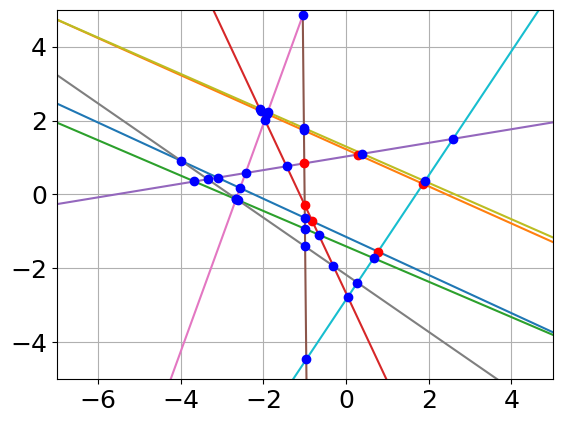

In [20]:
from itertools import combinations
x1=np.linspace(-10,10,200)
fig,ax=plt.subplots()
for k in range(len(W_1)):
    W_1_k_1=W_1[k,0]
    W_1_k_2=W_1[k,1]
    b_1_k=b_1[k]
    x2=(b_1_k-W_1_k_1*x1)/W_1_k_2
    ax.plot(x1,x2, label=str(k))
z_1=torch.Tensor([0,0])@W_1.T+b_1


lines=list(np.concatenate((np.array(W_1.detach().cpu()),np.array(b_1.detach().cpu()).reshape((-1,1))),axis=1))
vertices_list=[]
for l1, l2 in combinations(lines, 2):
    A = np.array([[l1[0], l1[1]], [l2[0], l2[1]]])
    b = np.array([l1[2], l2[2]])

    if np.linalg.det(A) != 0:
        x = np.linalg.solve(A, b)
        if x[0]<1.9 and x[0]>-1.1 and x[1]<1.1 and x[1]>-1.7:
            if not (x[1]<-0.3 and x[0]<-0.9):
              if not (x[1]<-0.8 and x[0]<0):
                vertices_list.append(x)
                plt.plot(x[0], x[1], 'ro')
              else:
                plt.plot(x[0], x[1], 'bo')
            else:
              plt.plot(x[0], x[1], 'bo')
        else:
            plt.plot(x[0], x[1], 'bo')

ax.set_xlim(-7,5)
ax.set_ylim(-5,5)


Now we can compute our new terminal set as the intersection

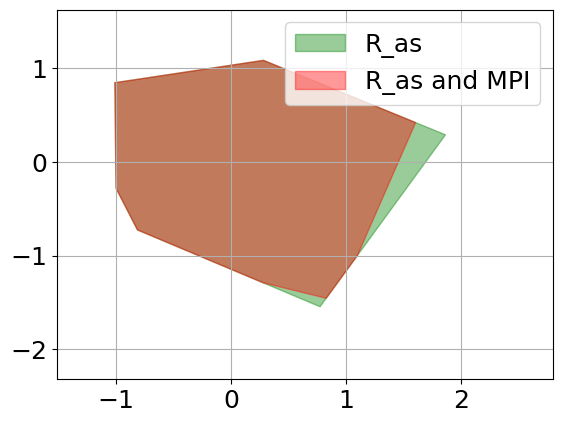

In [ ]:
plot_polygon(vertices_list,resize=True)
poly=polytope.qhull(np.array(vertices_list))
R_as=poly.A
r_as=poly.b.reshape((len(poly.b),1))

terminal_set_mat=np.concatenate((invariant_mat,R_as),axis=0)
terminal_set_vec=np.concatenate((one_vec,r_as),axis=0)
terminal_set=compute_polytope_vertices(terminal_set_mat,terminal_set_vec)

plot_polygon(terminal_set,resize=True,color='r')
plt.gca().legend(("R_as","R_as and MPI"))

Now we have to adjust the values of the last layer weights such that we can guarentee the stability

In [23]:

W_hat=cp.Variable((model.n_u,n_l))
b_hat=cp.Variable((model.n_u,1))
gamma=np.array((b_1>0).detach()).reshape(-1,1)
objective = cp.Minimize(cp.sum_squares(np.array(W_2.cpu().detach())-W_hat)+cp.sum_squares(np.array(b_2)-b_hat))
constraints=[]
W_eq=gamma*np.array(W_1.cpu().detach())
b_eq=gamma.T*np.array(b_1.cpu().detach())
print("Active weights in zero:\n"+str(W_eq))
print("Active bias in zero:\n"+str(b_eq))
constraints.append(W_hat@W_eq==-K_lqr)
constraints.append(W_hat@b_eq.reshape((-1,1))+b_hat-1==0)
prob = cp.Problem(objective,constraints)
prob.solve()
print("Old weights:\n"+str(W_2))
print("New adapted weights:\n"+str(W_hat.value))
print("Old bias:\n"+str(b_2))
print("New adapted weights:\n"+str(b_hat.value))
print("LQR value check:\n"+str(W_hat.value@W_eq))
with torch.no_grad():
  approx_mpc.net.layers[2].weight.copy_(torch.tensor(W_hat.value))
  approx_mpc.net.layers[2].bias.copy_(torch.tensor(b_hat.value).squeeze())

print("New value in zero:\n"+str(approx_mpc.make_step(np.array([[0],[0]]))))


Active weights in zero:
[[ 0.       0.     ]
 [ 0.35457  0.70711]
 [-0.14806 -0.30938]
 [-0.79804 -0.33452]
 [ 0.      -0.     ]
 [ 0.       0.     ]
 [ 0.      -0.     ]
 [-0.21645 -0.28012]
 [ 0.33112  0.67401]
 [-0.       0.     ]]
Active bias in zero:
[[-0.       0.86388  0.43421  0.89304 -0.      -0.      -0.       0.60851
   0.87393 -0.     ]]
Old weights:
tensor([[-0.6739,  0.6615, -0.5664,  0.2943,  0.2962,  0.0175,  0.1897, -0.4777,
          0.2506, -0.5013]])
New adapted weights:
[[-0.67393  0.65455 -0.56085  0.31048  0.29618  0.01752  0.18971 -0.47077
   0.24427 -0.50127]]
Old bias:
[0.47053]
New adapted weights:
[[0.47379]]
LQR value check:
[[0.25013 0.829  ]]
New value in zero:
[[0.]]


Let's take a lot at the closed-loop response of this new adapted AMPC.

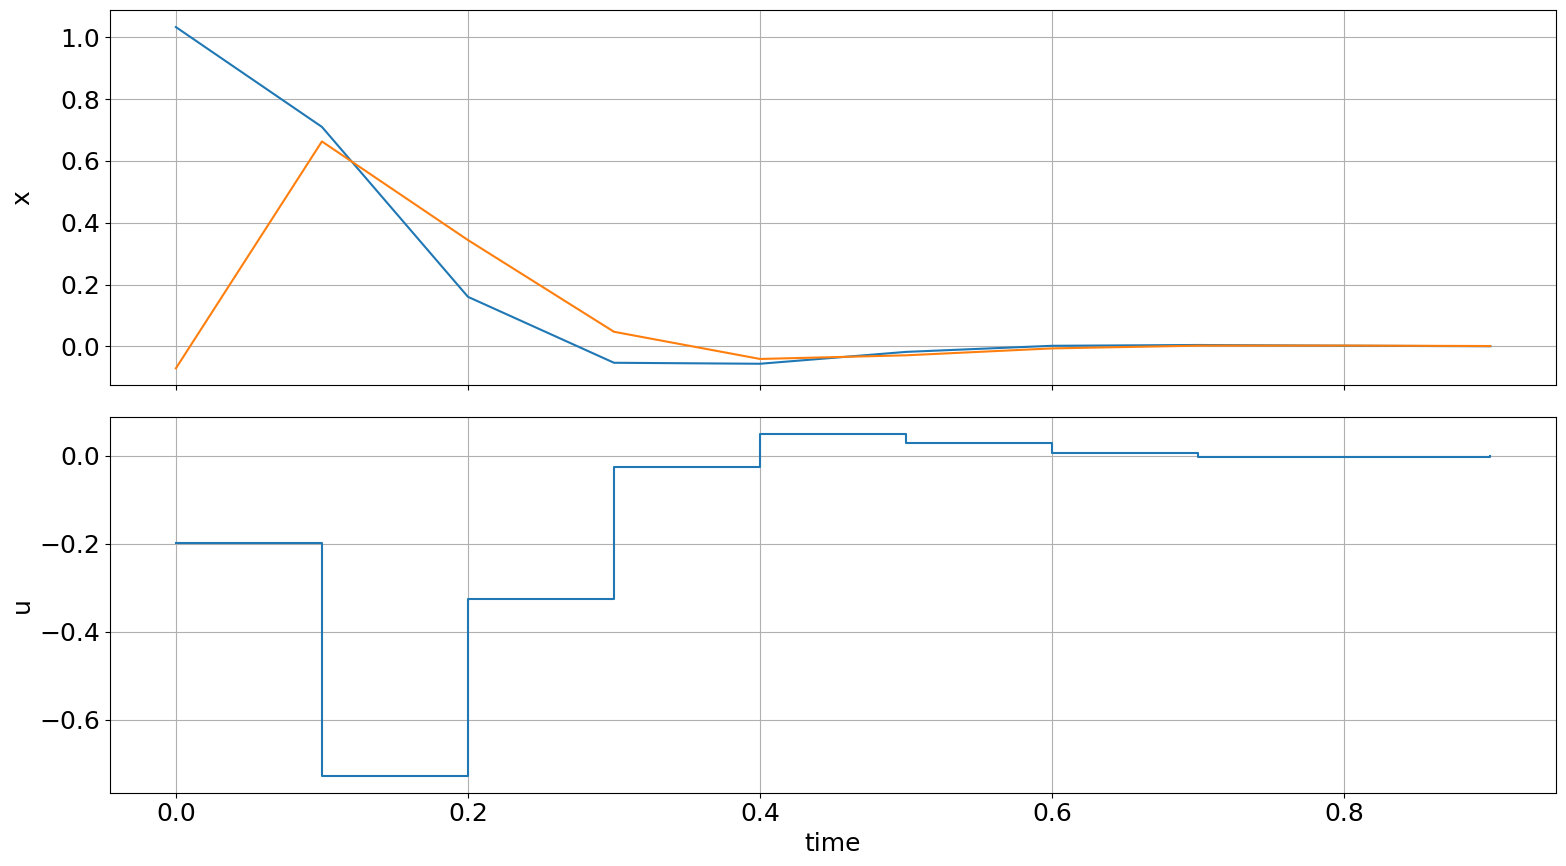

In [24]:
np.random.seed(99)
# Initial state
mpc.reset_history()
simulator.reset_history()
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()
for k in range(10):
    u0 = approx_mpc.make_step(x0,clip_to_bounds=False)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
fig, ax, graphics = do_mpc.graphics.default_plot(simulator.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()

## Output Range analysis for k=5 for guaranteeing stability
Finally, we can use the same optimization problem as before to guarantee that we will remain in the terminal set

In [1]:
xki_res=evaluate_set(C_in,c_in,1,terminal_set_mat,approx_mpc)
c_x=np.zeros((len(terminal_set_mat),1))
for m in range(len(terminal_set_mat)):
    c_x[m]=terminal_set_mat[m,:]@xki_res[m,:].reshape((model.n_x,1))

vertices_x=compute_polytope_vertices(terminal_set_mat,c_x)

xki_res=evaluate_set(terminal_set_mat,c_x,1,terminal_set_mat,approx_mpc)
c_x=np.zeros((len(terminal_set_mat),1))
for m in range(len(terminal_set_mat)):
    c_x[m]=terminal_set_mat[m,:]@xki_res[m,:].reshape((model.n_x,1))

vertices_x=compute_polytope_vertices(terminal_set_mat,c_x)

vertices_inv=compute_polytope_vertices(terminal_set_mat,terminal_set_vec)
plot_polygon(vertices_x,resize=True)
plot_polygon(vertices_inv,resize=True,color='r')
plt.gca().legend(("X_6","R_as"))

NameError: name 'evaluate_set' is not defined